## Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import mat73
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.stats import zscore
from pymultitaper import multitaper_spectrogram, plot_spectrogram

## Data Reading and PreProcessing

In [2]:
# Load .mat file
data = mat73.loadmat('./lfpUCLAC.mat')["lfpUCLAC"]
#data = mat73.loadmat('lfpUCLAC.mat')["lfpUCLAC"]
# Turn seizure data into a DataFrame
data = np.concatenate((data[:, :2], data[:, 11:]), axis=1)
column_names = ["Animal", "Session"]
column_names += [f"SZ_{i}" for i in range(11, 36012)]
seizure = pd.DataFrame(data, columns=column_names)
# Read Meta Data
#metadata = pd.read_csv("ADszNov7v21LeoIv2(in).csv")
metadata = pd.read_csv("./ADszNov7v21LeoIv3.csv")
# Merge two DataFrames
dataset = pd.merge(metadata, seizure, on=["Animal", "Session"], how='inner')

In [3]:
dataset

,Animal,Session,group,BaseStart,BaseEnd,NoSzstart2,NoSzend2,SzArtifactStart,SzArtifactEnd,SeizureStart,...,SZ_36002,SZ_36003,SZ_36004,SZ_36005,SZ_36006,SZ_36007,SZ_36008,SZ_36009,SZ_36010,SZ_36011
0,8790,2,1,-60.0,-20.0,6.0,120,-21.00,0,3.3,...,0.895588,0.866927,1.000345,1.083360,1.033944,0.890641,0.746350,0.860990,0.699898,0.401434
1,8799,2,1,-60.0,-11.0,30.0,120,-12.00,0,20.5,...,0.128512,0.141584,0.138678,0.087841,0.079126,0.025384,0.067505,-0.051598,0.006501,0.070409
2,12224,2,1,-60.0,-8.0,13.0,120,-7.50,0,8.5,...,0.009078,-0.023774,-0.006766,0.009076,-0.015155,-0.015389,0.014666,-0.004905,-0.014225,0.013500
3,12233,2,1,-60.0,-3.0,30.0,120,-2.00,0,10.0,...,0.001998,-0.022745,0.031218,-0.214643,0.020953,0.060175,-0.098818,0.052542,-0.026954,-0.019320
4,12234,2,1,-60.0,-2.0,39.0,120,-1.00,0,12.0,...,0.193024,-0.020621,0.196557,0.332058,0.345042,0.281896,0.317190,0.327150,0.339630,0.317448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164,12233,19,1,0.0,0.0,20.0,89,0.65,0,9.2,...,0.016741,0.099218,-0.023653,0.102346,0.103549,-0.060198,0.098502,0.002803,-0.011623,0.046087
165,8793,19,2,-60.0,-37.0,28.5,120,0.00,0,2.6,...,-0.588621,-0.241770,0.429002,0.486332,0.377403,0.214010,0.007618,0.050616,-0.045414,0.133745
166,8797,19,2,-60.0,-53.0,40.0,120,0.00,0,3.3,...,0.074535,-0.049774,-0.050855,0.014002,0.137230,0.119934,0.122096,0.004272,0.018324,0.037781
167,12227,19,2,-60.0,-3.0,46.0,120,0.40,0,8.8,...,0.420122,0.379910,0.380465,0.387676,0.385735,0.359945,0.362996,0.341087,0.320843,0.318070


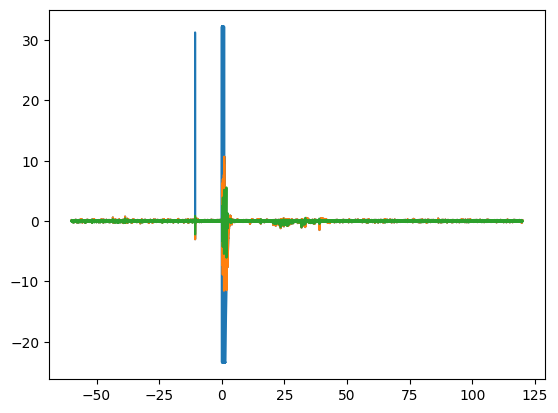

In [4]:
# Design the bandpass filter
b, a = butter(8, [4, 50], 
              btype='bandpass', fs=200)

# Apply zero-phase filtering
rawlfp = dataset.loc[:, "SZ_11":]
rawlfp = rawlfp.to_numpy()

start = -60
stop = 120

t_lfp = np.linspace(start, stop, rawlfp.shape[1]) 
t_base = np.where(t_lfp<=2)
# t_mask = (t_lfp <= -2) | (t_lfp >= 2)
# t_lfp_noNoise = t_lfp[t_mask]
# rawlfp_noNoise = rawlfp[:, t_mask]
# print(t_lfp,t_lfp.shape, rawlfp_noNoise.shape, t_lfp_noNoise.shape)
lfp_f = rawlfp.copy()
# reduce amplitude of noise in raw lfp
for lfp_in in range(rawlfp.shape[0]): 
    lfp_f[lfp_in,:] = rawlfp[lfp_in,:]
    lfp_b = lfp_f[lfp_in,t_base]
    std_b = np.std(lfp_b)
    mean_b = np.mean(lfp_b)
    thresh_b = 3 * std_b
    mask_b = np.abs(lfp_b-mean_b) <= thresh_b
    lfp_b[~mask_b] = 0
    lfp_f[lfp_in,t_base] = lfp_b

# rawlfp_noNoise = zscore(rawlfp_noNoise, axis=1)
# for lfp_in in range(rawlfp_noNoise.shape[0]):
#     min_lfp = np.min(rawlfp_noNoise[lfp_in,:])
#     max_lfp = np.max(rawlfp_noNoise[lfp_in,:])
#     rawlfp_noNoise[lfp_in,:] = rawlfp_noNoise[lfp_in,:] - min_lfp / (max_lfp - min_lfp) * 10
fast = filtfilt(b, a, lfp_f)
plt.figure()
plt.plot(t_lfp,rawlfp[1,:])
plt.plot(t_lfp,lfp_f[1,:])
plt.plot(t_lfp, fast[1,:])


In [5]:
print(fast.dtype, fast.shape)
print(rawlfp.shape)

float64 (169, 36001)
(169, 36001)


In [7]:
# Compute the multitaper spectrogram
fs = 200
psdWindowStep = 0.5
windowtimelength = 5
freqs, times, psd = multitaper_spectrogram(fast[1,:], fs, time_step=psdWindowStep, 
                                           window_length=1.0, NW=4)


In [10]:
low_freq = 5   # Hz
high_freq = 30 # Hz
def bandpass_filter_spectrogram(freqs, psd, low_freq, high_freq):
    """Extract only the desired frequency range from spectrogram"""
    # Find frequency indices
    freq_indices = (freqs >= low_freq) & (freqs <= high_freq)
    
    # Extract bandpass frequencies and PSD
    freqs_bp = freqs[freq_indices]
    psd_bp = psd[freq_indices,:]
    
    return freqs_bp, psd_bp


In [12]:
def zscorepsd_data(datapsd):
    datapsd = zscore(datapsd, axis=None)
    min_psd = np.min(datapsd)
    max_psd = np.max(datapsd)
    datapsd = datapsd - min_psd / (max_psd - min_psd) * 10
    return datapsd

In [13]:
# times.shape
# in_base_psd = np.where((times>= metadata.BaseStart[1]) & (times<= metadata.BaseEnd[1]))[0]
# print(len(in_base_psd))
# print(times[in_base_psd])
# print(psd_tempFilt.shape)
# print(psd_tempFilt[:, in_base_psd].shape)
# psd_base = np.mean(psd_tempFilt[:, in_base_psd], axis=1)
# print(psd_base.shape)
# print(psd_tempFilt.shape)

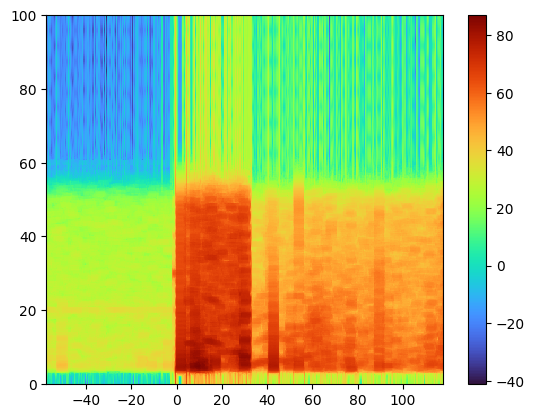

(513, 351) (513,) (351,)
(128, 351) (128,) (351,)
(1,)


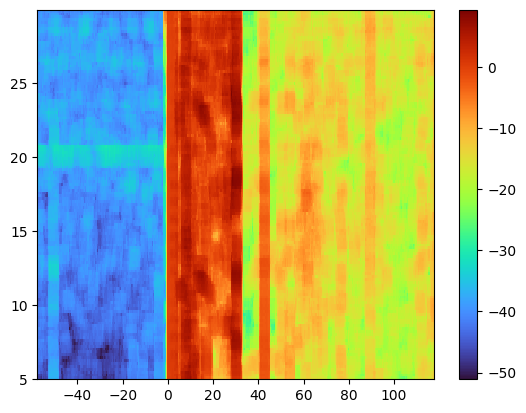

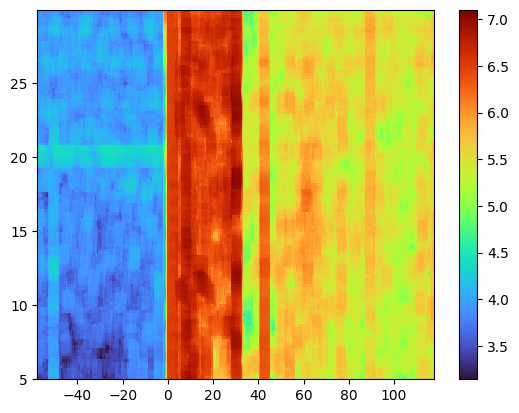

In [14]:
# Parameters
fs = 200
freq_indices = (freqs >= low_freq) & (freqs <= high_freq)
session_testid = 162
# Get dimensions from first row to initialize the 3D matrix
freqs, times, psd_temp = multitaper_spectrogram(fast[session_testid,:], fs, time_step=psdWindowStep, 
                                                window_length=windowtimelength, NW=4)
times = times - 60

plt.pcolormesh(times, freqs, psd_temp, cmap = 'turbo', shading='auto')
plt.colorbar()
plt.show()
print(psd_temp.shape, freqs.shape, times.shape)
#print(times,freqs)
freqsFilt, psd_tempFilt = bandpass_filter_spectrogram(freqs, psd_temp, low_freq, high_freq) 
print(psd_tempFilt.shape, freqsFilt.shape, times.shape)
#print(times, freqsFilt)



def base_norm_psd(psd_data, session_testid,times):
    in_base_psd = np.where((times>= metadata.BaseStart[session_testid]) & (times<= metadata.BaseEnd[session_testid]))[0]
    in_sz_psd = np.where((times>= metadata.SeizureStart[session_testid]) & (times<= metadata.SeizureEnd[session_testid]))[0]
    if len(in_sz_psd) == 0:
        psd_norm = psd_data.copy()
        print("No Seizure")
    else: 
        if len(in_base_psd) == 0:
            psd_norm = psd_data.copy()
            times_base = times.copy()
            print(times_base.shape)
        else:
            psd_norm = psd_data.copy()
            psd_base = np.mean(psd_data[:, in_base_psd], axis=1)
            # psd_norm[:, in_sz_psd] = psd_data[:, in_sz_psd] - psd_base.reshape(len(psd_base),1)
            psd_norm = psd_data - psd_base.reshape(len(psd_base),1)
            times_base = times[in_base_psd]
            print(times_base.shape)
    return psd_norm

psd_tempFilt = base_norm_psd(psd_tempFilt, session_testid=session_testid, times=times)

plt.pcolormesh(times, freqsFilt, psd_tempFilt, cmap = 'turbo', shading='auto')
plt.colorbar()
plt.show()

psd_tempFilt = zscorepsd_data(psd_tempFilt)
plt.pcolormesh(times, freqsFilt, psd_tempFilt, cmap = 'turbo', shading='auto')
plt.colorbar()
plt.show()


In [15]:
# Initialize 3D matrix: (n_sessions, n_freqs, n_times)
n_sessions = fast.shape[0]
n_freqs = len(freqsFilt)
n_times = len(times)
psd_3d = np.zeros((n_sessions, n_freqs, n_times))

print(f"Processing {n_sessions} sessions...")
print(f"PSD matrix shape will be: ({n_sessions}, {n_freqs}, {n_times})")

# Loop through all rows (sessions)
for session in range(n_sessions):
    print(f"Processing session {session + 1}/{n_sessions}")
    
    # Get spectrogram for this session
    freqs, times,  psd = multitaper_spectrogram(fast[session,:], fs, time_step=psdWindowStep, 
                                               window_length=windowtimelength, NW=4)
    times = times - 60
    # Convert to log scale
    #psd = np.interp(psd, (psd.min(), psd.max()), (0, 10))
    #psd_log = 10 * np.log10(psd)
    #psd_log = np.interp(psd_log, (psd_log.min(), psd_log.max()), (0, 10))
    
    freqs, psd = bandpass_filter_spectrogram(freqs, psd, low_freq, high_freq)
    psd = base_norm_psd(psd, session_testid=session,times=times)
    psd = zscorepsd_data(psd)
    
    
    # Store in 3D matrix
    
    psd_3d[session, :, :] = psd

print("Done! 3D PSD matrix created.")
print(f"Final shape: {psd_3d.shape}")
print(f"Shape interpretation: (sessions={psd_3d.shape[0]}, freqs={psd_3d.shape[1]}, times={psd_3d.shape[2]})")

Processing 169 sessions...
PSD matrix shape will be: (169, 128, 351)
Processing session 1/169
(76,)
Processing session 2/169
(94,)
Processing session 3/169
(100,)
Processing session 4/169
(110,)
Processing session 5/169
(112,)
Processing session 6/169
(104,)
Processing session 7/169
(76,)
Processing session 8/169
(112,)
Processing session 9/169
(112,)
Processing session 10/169
(112,)
Processing session 11/169
(112,)
Processing session 12/169
(71,)
Processing session 13/169
(100,)
Processing session 14/169
(112,)
Processing session 15/169
(82,)
Processing session 16/169
(92,)
Processing session 17/169
(112,)
Processing session 18/169
(112,)
Processing session 19/169
(112,)
Processing session 20/169
(88,)
Processing session 21/169
(84,)
Processing session 22/169
(98,)
Processing session 23/169
(108,)
Processing session 24/169
(106,)
Processing session 25/169
(88,)
Processing session 26/169
(112,)
Processing session 27/169
(110,)
Processing session 28/169
(110,)
Processing session 29/169


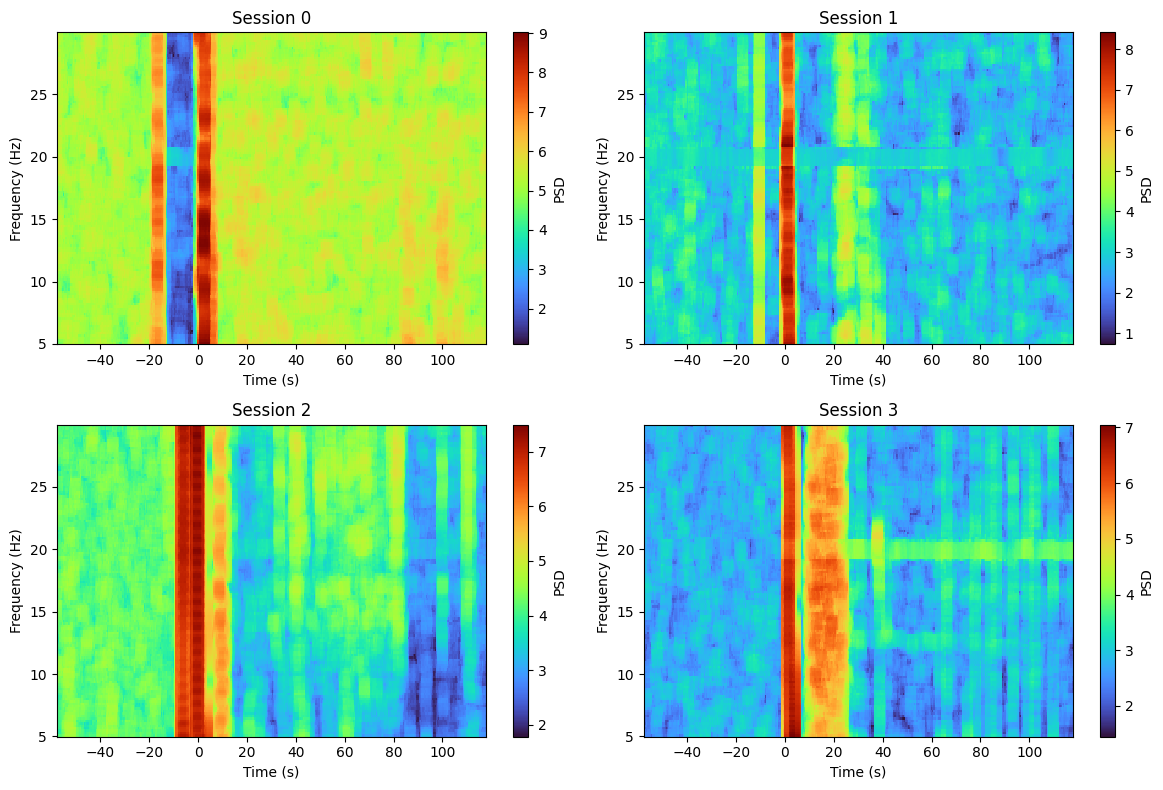

In [16]:
# Example: Plot a few channels
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for i in range(min(4, n_sessions)):  # Plot first 4 channels
    im = axes[i].pcolormesh(times, freqs, psd_3d[i], cmap = 'turbo', shading='auto')
    axes[i].set_title(f'Session {i}')
    axes[i].set_xlabel('Time (s)')
    axes[i].set_ylabel('Frequency (Hz)')
    plt.colorbar(im, ax=axes[i], label='PSD')

plt.tight_layout()
plt.show()


In [17]:
#times -= 60
psd_3d[2,:,:].min()
print(psd_3d.shape)

(169, 128, 351)


In [18]:
import math
def time2index(time, start, psdWindowStep):
    return math.floor((time - start) / psdWindowStep)

In [19]:
start = -60
times_to_convert = ["BaseStart", "BaseEnd","SeizureStart", "SeizureEnd", "SzArtifactStart", "SzArtifactEnd"]
for column_name in times_to_convert:
    dataset[column_name] = dataset[column_name].apply(lambda x: time2index(x, start=start, psdWindowStep=psdWindowStep))
    #dataset[column_name] = dataset[column_name].astype(int)

In [30]:
print(metadata.Animal.dtype)
print(dataset.loc[:,"Animal"].dtype)
print(psd_3d.shape)
print(dataset)

int64
int64
(169, 128, 351)
     Animal  Session  group  BaseStart  BaseEnd  NoSzstart2  NoSzend2  \
0      8790        2      1          0       80         6.0       120   
1      8799        2      1          0       98        30.0       120   
2     12224        2      1          0      104        13.0       120   
3     12233        2      1          0      114        30.0       120   
4     12234        2      1          0      116        39.0       120   
..      ...      ...    ...        ...      ...         ...       ...   
164   12233       19      1        120      120        20.0        89   
165    8793       19      2          0       46        28.5       120   
166    8797       19      2          0       14        40.0       120   
167   12227       19      2          0      114        46.0       120   
168   12228       19      2        120      120        29.0       120   

     SzArtifactStart  SzArtifactEnd  SeizureStart  ...  SZ_36002  SZ_36003  \
0                

In [ ]:
def extract_samples(idx, time_row):        
    time_row = time_row.astype(int)
    animal_id = dataset.loc[idx, "Animal"]
    base = psd_3d[idx, :, time_row["BaseStart"]: time_row["BaseEnd"]]
    seizure = psd_3d[idx, :, time_row["SeizureStart"]: time_row["SeizureEnd"]]
    artifact = psd_3d[idx, :, time_row["SzArtifactStart"]: time_row["SzArtifactEnd"]]
    return base.T, seizure.T, artifact.T, animal_id

In [ ]:
feature_dim = psd_3d.shape[1] 
animalID = 8790
all_base = np.empty((0, feature_dim))
all_seizure = np.empty((0, feature_dim))
all_artifact = np.empty((0, feature_dim))
# animal id = 8790, 8799, 8800, 8798, 8797, 12233, 12234, 12226, 12227, 12228, 12229, 12224

for i in range(len(dataset)):
    #if dataset.loc[i,"Animal"]==animalID:
    base, seizure, artifact, animal_id = extract_samples(i, dataset.loc[i, times_to_convert])
    all_base = np.concatenate((all_base, base), axis=0)
    all_seizure = np.concatenate((all_seizure, seizure), axis=0)
    all_artifact = np.concatenate((all_artifact, artifact), axis=0)

In [ ]:
BASE_LABEL = 0
ARTIFACT_LABEL = 1
SEIZURE_LABEL = 2

(0, 128)


NameError: name 'time_row' is not defined

In [ ]:
base_label_arr = np.ones(shape=(len(all_base), 1)) * BASE_LABEL
artifact_label_arr = np.ones(shape=(len(all_artifact), 1)) * ARTIFACT_LABEL
seizure_label_arr = np.ones(shape=(len(all_seizure), 1)) * SEIZURE_LABEL

In [ ]:
all_base = np.concatenate((all_base, base_label_arr), axis=1)
all_artifact = np.concatenate((all_artifact, artifact_label_arr), axis=1)
all_seizure = np.concatenate((all_seizure, seizure_label_arr), axis=1)

In [ ]:
print(all_seizure.shape,all_base.shape)

(6329, 129) (12627, 129)


In [ ]:
all_data = np.concatenate((all_base, all_artifact, all_seizure), axis=0)
all_data.shape

(19154, 129)

In [ ]:
np.random.shuffle(all_data)
all_data.shape

(19154, 129)

# Modelling

## Imports

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import load_iris
import scipy
from tqdm import tqdm
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import random
import math
import copy


## Helper Functions

In [ ]:
def plot_train_val_test_accuracy(train_acc, val_acc, test_acc):
  epochs = list(range(1, len(train_acc) + 1))

    # Create the figure
  fig = go.Figure()

    # Add traces
  fig.add_trace(
        go.Scatter(
            x=epochs,
            y=train_acc,
            name="Train Accuracy",
            mode='lines',
            line=dict(color='#8b5cf6', width=2),
            hovertemplate="Epoch %{x}<br>Accuracy: %{y:.4f}<extra></extra>"
        )
    )

  fig.add_trace(
        go.Scatter(
            x=epochs,
            y=val_acc,
            name="Validation Accuracyy",
            mode='lines',
            line=dict(color='#22c55e', width=2),
            hovertemplate="Epoch %{x}<br>Accuracy: %{y:.4f}<extra></extra>"
        )
    )

  fig.add_trace(
        go.Scatter(
            x=epochs,
            y=test_acc,
            name="Test Accuracyy",
            mode='lines',
            line=dict(color='#800080', width=2),
            hovertemplate="Epoch %{x}<br>Accuracy: %{y:.4f}<extra></extra>"
        )
    )


    # Update layout
  fig.update_layout(
        title=dict(
            text="Training, Validation and Test Accuracy over Epochs",
            x=0.5,
            y=0.95,
            xanchor='center',
            yanchor='top'
        ),
        xaxis_title="Epochs",
        yaxis_title="Accuracy",
        hovermode='x unified',
        template='plotly_white',
        xaxis=dict(
            tickmode='linear',
            tick0=1,
            dtick=max(1, len(epochs) // 10)  # Show ~10 ticks on x-axis
        ),
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="right",
            x=0.99
        )
    )

  fig.show()


In [ ]:
def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [ ]:
# @title Set device (GPU or CPU).
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [ ]:
SEED = 42
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 42 has been set.
GPU is enabled in this notebook.


## Model Definition

In [ ]:
class FFN(nn.Module):

    @staticmethod
    def he_uniform_init(layer):
        """
        Apply He Uniform Initialization to the layer's weights and optionally biases
        """
        if isinstance(layer, nn.Linear):
            nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)  # common practice is to zero biases

    def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num, has_batch_norm=True):
        """
        Initialize Feed-Forward Network parameters
        """
        super(FFN, self).__init__()
        self.input_feature_num = input_feature_num
        self.ffn = nn.Sequential()
        in_num = input_feature_num

        for layer_index, out_num in enumerate(hidden_unit_nums):
            layer = nn.Linear(in_num, out_num, bias=True)
            self.he_uniform_init(layer)  # Apply He initialization here
            self.ffn.add_module(f"Linear_{layer_index}", layer)

            # Batch Normalization Layer
            if has_batch_norm:
                self.ffn.add_module(f"BatchNorm_{layer_index}", nn.BatchNorm1d(out_num))

            actv_layer = eval(f"nn.{actv}")  
            self.ffn.add_module(f"Activation_{layer_index}", actv_layer)

            in_num = out_num

        out_layer = nn.Linear(in_num, output_feature_num, bias=True)
        self.he_uniform_init(out_layer)  
        self.ffn.add_module(f'Linear_{len(hidden_unit_nums)}', out_layer)

    def forward(self, x):
        x = x.view(-1, self.input_feature_num)
        return self.ffn(x)


## Defining DataLoaders

In [ ]:
X = all_data[:, :-1]  # features 
y = all_data[:, -1]   # labels  

# Split using sklearn
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1, random_state=SEED)
# Convert to tensors
X_train_tensor, y_train_tensor = torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long)  # or float32 for regression
X_val_tensor, y_val_tensor = torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long)
X_test_tensor, y_test_tensor = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)

# Wrap in TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [ ]:
batch_size = 512
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

def get_data_loaders(train_dataset, val_dataset, test_dataset):

  train_loader = DataLoader(train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )


  val_loader = DataLoader(val_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                        )

  test_loader = DataLoader(test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         worker_init_fn=seed_worker,
                         generator=g_seed,
                        )
  return train_loader, val_loader, test_loader


train_loader, val_loader, test_loader = get_data_loaders(train_dataset, val_dataset, test_dataset)

## Training Loop

In [ ]:
def get_model_accuracy(net, data_loader, device=DEVICE):
  correct = 0
  net.eval()  # Set model to evaluation mode
  with torch.no_grad():  # No need to track gradients
    for inputs, labels in data_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      y_pred = torch.argmax(net(inputs), dim=1)
      correct += (labels == y_pred).sum().item()
  accuracy = (correct / len(data_loader.dataset)) * 100
  return accuracy


def get_loss(net, criterion, data_loader, device=DEVICE):
    net.eval() #Set model to evaluation mode
    with torch.no_grad():
        running_loss = 0.0
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
    return running_loss / len(data_loader)




def train_eval_model(net, criterion, optimizer, train_loader, valid_loader, test_loader, num_epochs, validation_freq, verbose=True, device=DEVICE):
    net.to(device)
    training_accuracy, validation_accuracy, test_accuracy = [], [], []
    for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
        net.train()
        running_loss = 0.
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # add current loss to running_loss
            running_loss += loss.detach().item()
        train_loss = running_loss / len(train_loader)
        if verbose:
          print(f"Epoch {epoch}: Train Loss {train_loss}")
        # save accuracy and loss for plotting
        if epoch % validation_freq == 0:
            validation_accuracy.append(get_model_accuracy(net, valid_loader))
            test_accuracy.append(get_model_accuracy(net, test_loader))
            training_accuracy.append(get_model_accuracy(net, train_loader))
    return net, training_accuracy, validation_accuracy, test_accuracy


In [ ]:
actv = "ReLU()"
input_feature_num = feature_dim
hidden_unit_nums = [4096, 2048, 1024, 512, 256, 128]
output_feature_num = 3
max_epochs = 300
criterion = nn.CrossEntropyLoss()
mlp = FFN(actv, input_feature_num, hidden_unit_nums, output_feature_num)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)

In [ ]:
net, train_acc, valid_acc, test_acc = train_eval_model(mlp, criterion, optimizer, train_loader, val_loader, test_loader, max_epochs, validation_freq=10)

  0%|          | 1/300 [00:00<02:26,  2.04it/s]

Epoch 0: Train Loss 0.3962050349481644


  1%|          | 2/300 [00:00<01:51,  2.68it/s]

Epoch 1: Train Loss 0.2706317166166921


  1%|          | 3/300 [00:01<01:39,  3.00it/s]

Epoch 2: Train Loss 0.24516554032602617


  1%|▏         | 4/300 [00:01<01:33,  3.18it/s]

Epoch 3: Train Loss 0.20944615669788852


  2%|▏         | 5/300 [00:01<01:30,  3.28it/s]

Epoch 4: Train Loss 0.19490413031270426


  2%|▏         | 6/300 [00:01<01:28,  3.31it/s]

Epoch 5: Train Loss 0.18650281381222508


  2%|▏         | 7/300 [00:02<01:27,  3.35it/s]

Epoch 6: Train Loss 0.17784001029306842


  3%|▎         | 8/300 [00:02<01:26,  3.39it/s]

Epoch 7: Train Loss 0.16923901919395692


  3%|▎         | 9/300 [00:02<01:25,  3.42it/s]

Epoch 8: Train Loss 0.14549491915010637


  3%|▎         | 10/300 [00:03<01:24,  3.42it/s]

Epoch 9: Train Loss 0.15068118322280147


  4%|▎         | 11/300 [00:03<01:33,  3.10it/s]

Epoch 10: Train Loss 0.15369655840819882


  4%|▍         | 12/300 [00:03<01:29,  3.21it/s]

Epoch 11: Train Loss 0.13817667937086475


  4%|▍         | 13/300 [00:04<01:28,  3.26it/s]

Epoch 12: Train Loss 0.13878685836830446


  5%|▍         | 14/300 [00:04<01:26,  3.32it/s]

Epoch 13: Train Loss 0.12741280275006447


  5%|▌         | 15/300 [00:04<01:33,  3.03it/s]

Epoch 14: Train Loss 0.12178725941527274


  5%|▌         | 16/300 [00:05<01:30,  3.15it/s]

Epoch 15: Train Loss 0.13037992725449224


  6%|▌         | 17/300 [00:05<01:27,  3.24it/s]

Epoch 16: Train Loss 0.1329611258641366


  6%|▌         | 18/300 [00:05<01:25,  3.31it/s]

Epoch 17: Train Loss 0.11972547178306887


  6%|▋         | 19/300 [00:05<01:23,  3.35it/s]

Epoch 18: Train Loss 0.11051381571638969


  7%|▋         | 20/300 [00:06<01:22,  3.40it/s]

Epoch 19: Train Loss 0.11613604186042663


  7%|▋         | 21/300 [00:06<01:30,  3.10it/s]

Epoch 20: Train Loss 0.11246350191293224


  7%|▋         | 22/300 [00:06<01:26,  3.21it/s]

Epoch 21: Train Loss 0.11417278935832362


  8%|▊         | 23/300 [00:07<01:24,  3.28it/s]

Epoch 22: Train Loss 0.11324256057700803


  8%|▊         | 24/300 [00:07<01:22,  3.34it/s]

Epoch 23: Train Loss 0.11141671576807576


  8%|▊         | 25/300 [00:07<01:21,  3.38it/s]

Epoch 24: Train Loss 0.09543595823549456


  9%|▊         | 26/300 [00:08<01:20,  3.40it/s]

Epoch 25: Train Loss 0.10173052501293921


  9%|▉         | 27/300 [00:08<01:19,  3.43it/s]

Epoch 26: Train Loss 0.1049034045107903


  9%|▉         | 28/300 [00:08<01:18,  3.44it/s]

Epoch 27: Train Loss 0.09882324525425511


 10%|▉         | 29/300 [00:08<01:18,  3.46it/s]

Epoch 28: Train Loss 0.08368306799281028


 10%|█         | 30/300 [00:09<01:17,  3.47it/s]

Epoch 29: Train Loss 0.08893629740322789


 10%|█         | 31/300 [00:09<01:25,  3.14it/s]

Epoch 30: Train Loss 0.09412747921962891


 11%|█         | 32/300 [00:09<01:22,  3.24it/s]

Epoch 31: Train Loss 0.09464807952603986


 11%|█         | 33/300 [00:10<01:20,  3.31it/s]

Epoch 32: Train Loss 0.08683840029181973


 11%|█▏        | 34/300 [00:10<01:19,  3.37it/s]

Epoch 33: Train Loss 0.08384246595444218


 12%|█▏        | 35/300 [00:10<01:25,  3.09it/s]

Epoch 34: Train Loss 0.07330540110988001


 12%|█▏        | 36/300 [00:11<01:22,  3.20it/s]

Epoch 35: Train Loss 0.09093069934075879


 12%|█▏        | 37/300 [00:11<01:20,  3.28it/s]

Epoch 36: Train Loss 0.08399301514990869


 13%|█▎        | 38/300 [00:11<01:18,  3.35it/s]

Epoch 37: Train Loss 0.07727918557582363


 13%|█▎        | 39/300 [00:11<01:16,  3.40it/s]

Epoch 38: Train Loss 0.07263743252523484


 13%|█▎        | 40/300 [00:12<01:15,  3.42it/s]

Epoch 39: Train Loss 0.07406864795953996


 14%|█▎        | 41/300 [00:12<01:23,  3.12it/s]

Epoch 40: Train Loss 0.07416931239347305


 14%|█▍        | 42/300 [00:12<01:20,  3.22it/s]

Epoch 41: Train Loss 0.0757859762637846


 14%|█▍        | 43/300 [00:13<01:17,  3.31it/s]

Epoch 42: Train Loss 0.08244722853264501


 15%|█▍        | 44/300 [00:13<01:16,  3.36it/s]

Epoch 43: Train Loss 0.06434775191930033


 15%|█▌        | 45/300 [00:13<01:14,  3.40it/s]

Epoch 44: Train Loss 0.06373268437962379


 15%|█▌        | 46/300 [00:14<01:14,  3.43it/s]

Epoch 45: Train Loss 0.06654733317273279


 16%|█▌        | 47/300 [00:14<01:13,  3.44it/s]

Epoch 46: Train Loss 0.06033088182730059


 16%|█▌        | 48/300 [00:14<01:13,  3.45it/s]

Epoch 47: Train Loss 0.060420257069410815


 16%|█▋        | 49/300 [00:14<01:12,  3.47it/s]

Epoch 48: Train Loss 0.05945147994545198


 17%|█▋        | 50/300 [00:15<01:12,  3.47it/s]

Epoch 49: Train Loss 0.06357099482369039


 17%|█▋        | 51/300 [00:15<01:19,  3.14it/s]

Epoch 50: Train Loss 0.0657738161784026


 17%|█▋        | 52/300 [00:15<01:16,  3.24it/s]

Epoch 51: Train Loss 0.053151407309116855


 18%|█▊        | 53/300 [00:16<01:14,  3.31it/s]

Epoch 52: Train Loss 0.050016534484682545


 18%|█▊        | 54/300 [00:16<01:13,  3.36it/s]

Epoch 53: Train Loss 0.054404546957342856


 18%|█▊        | 55/300 [00:16<01:19,  3.07it/s]

Epoch 54: Train Loss 0.06310473208225542


 19%|█▊        | 56/300 [00:17<01:16,  3.19it/s]

Epoch 55: Train Loss 0.05639089523784576


 19%|█▉        | 57/300 [00:17<01:14,  3.28it/s]

Epoch 56: Train Loss 0.06528935389172646


 19%|█▉        | 58/300 [00:17<01:12,  3.35it/s]

Epoch 57: Train Loss 0.06310607360736016


 20%|█▉        | 59/300 [00:17<01:11,  3.38it/s]

Epoch 58: Train Loss 0.05906880136218763


 20%|██        | 60/300 [00:18<01:10,  3.42it/s]

Epoch 59: Train Loss 0.05470170765634506


 20%|██        | 61/300 [00:18<01:16,  3.12it/s]

Epoch 60: Train Loss 0.05424776769453479


 21%|██        | 62/300 [00:18<01:13,  3.22it/s]

Epoch 61: Train Loss 0.052857471629977226


 21%|██        | 63/300 [00:19<01:11,  3.30it/s]

Epoch 62: Train Loss 0.05065557679101344


 21%|██▏       | 64/300 [00:19<01:10,  3.35it/s]

Epoch 63: Train Loss 0.04471841944201339


 22%|██▏       | 65/300 [00:19<01:09,  3.40it/s]

Epoch 64: Train Loss 0.04927629394637


 22%|██▏       | 66/300 [00:20<01:08,  3.42it/s]

Epoch 65: Train Loss 0.04203854885793502


 22%|██▏       | 67/300 [00:20<01:07,  3.45it/s]

Epoch 66: Train Loss 0.04761996216350986


 23%|██▎       | 68/300 [00:20<01:07,  3.46it/s]

Epoch 67: Train Loss 0.04064543851681294


 23%|██▎       | 69/300 [00:20<01:06,  3.47it/s]

Epoch 68: Train Loss 0.039104068771966045


 23%|██▎       | 70/300 [00:21<01:06,  3.47it/s]

Epoch 69: Train Loss 0.03797937232640482


 24%|██▎       | 71/300 [00:21<01:12,  3.16it/s]

Epoch 70: Train Loss 0.041687166558638696


 24%|██▍       | 72/300 [00:21<01:09,  3.26it/s]

Epoch 71: Train Loss 0.03807328710512769


 24%|██▍       | 73/300 [00:22<01:08,  3.32it/s]

Epoch 72: Train Loss 0.03767507475230002


 25%|██▍       | 74/300 [00:22<01:07,  3.36it/s]

Epoch 73: Train Loss 0.05253882483849602


 25%|██▌       | 75/300 [00:22<01:06,  3.39it/s]

Epoch 74: Train Loss 0.06246786895057847


 25%|██▌       | 76/300 [00:23<01:12,  3.10it/s]

Epoch 75: Train Loss 0.04585853573535719


 26%|██▌       | 77/300 [00:23<01:09,  3.20it/s]

Epoch 76: Train Loss 0.039113080489539334


 26%|██▌       | 78/300 [00:23<01:07,  3.28it/s]

Epoch 77: Train Loss 0.039545937591502746


 26%|██▋       | 79/300 [00:24<01:06,  3.34it/s]

Epoch 78: Train Loss 0.04283363786676238


 27%|██▋       | 80/300 [00:24<01:04,  3.39it/s]

Epoch 79: Train Loss 0.03689109732306773


 27%|██▋       | 81/300 [00:24<01:10,  3.10it/s]

Epoch 80: Train Loss 0.048306979539413604


 27%|██▋       | 82/300 [00:24<01:08,  3.20it/s]

Epoch 81: Train Loss 0.04275743519106219


 28%|██▊       | 83/300 [00:25<01:06,  3.28it/s]

Epoch 82: Train Loss 0.040174013424304225


 28%|██▊       | 84/300 [00:25<01:04,  3.34it/s]

Epoch 83: Train Loss 0.05128786316321742


 28%|██▊       | 85/300 [00:25<01:03,  3.39it/s]

Epoch 84: Train Loss 0.04273602204217065


 29%|██▊       | 86/300 [00:26<01:02,  3.41it/s]

Epoch 85: Train Loss 0.03338894181914868


 29%|██▉       | 87/300 [00:26<01:02,  3.43it/s]

Epoch 86: Train Loss 0.04604761182300506


 29%|██▉       | 88/300 [00:26<01:01,  3.44it/s]

Epoch 87: Train Loss 0.047222263750530055


 30%|██▉       | 89/300 [00:26<01:01,  3.45it/s]

Epoch 88: Train Loss 0.04486544201931646


 30%|███       | 90/300 [00:27<01:00,  3.46it/s]

Epoch 89: Train Loss 0.03701006098380012


 30%|███       | 91/300 [00:27<01:06,  3.14it/s]

Epoch 90: Train Loss 0.03908553569307251


 31%|███       | 92/300 [00:27<01:04,  3.22it/s]

Epoch 91: Train Loss 0.036075349416463606


 31%|███       | 93/300 [00:28<01:02,  3.30it/s]

Epoch 92: Train Loss 0.037327117196494536


 31%|███▏      | 94/300 [00:28<01:01,  3.35it/s]

Epoch 93: Train Loss 0.02916063584627644


 32%|███▏      | 95/300 [00:28<01:00,  3.39it/s]

Epoch 94: Train Loss 0.028033484584621845


 32%|███▏      | 96/300 [00:29<01:06,  3.08it/s]

Epoch 95: Train Loss 0.03311866855308894


 32%|███▏      | 97/300 [00:29<01:03,  3.18it/s]

Epoch 96: Train Loss 0.03271553551237429


 33%|███▎      | 98/300 [00:29<01:01,  3.26it/s]

Epoch 97: Train Loss 0.04090059906124107


 33%|███▎      | 99/300 [00:30<01:00,  3.33it/s]

Epoch 98: Train Loss 0.03589647900192968


 33%|███▎      | 100/300 [00:30<00:59,  3.37it/s]

Epoch 99: Train Loss 0.02949278017566089


 34%|███▎      | 101/300 [00:30<01:04,  3.09it/s]

Epoch 100: Train Loss 0.031083773431037704


 34%|███▍      | 102/300 [00:31<01:01,  3.20it/s]

Epoch 101: Train Loss 0.03469571825717726


 34%|███▍      | 103/300 [00:31<01:00,  3.28it/s]

Epoch 102: Train Loss 0.03637200915404866


 35%|███▍      | 104/300 [00:31<00:58,  3.34it/s]

Epoch 103: Train Loss 0.04329421587528721


 35%|███▌      | 105/300 [00:31<00:57,  3.38it/s]

Epoch 104: Train Loss 0.05124539984089713


 35%|███▌      | 106/300 [00:32<00:56,  3.41it/s]

Epoch 105: Train Loss 0.03846978976000701


 36%|███▌      | 107/300 [00:32<00:56,  3.43it/s]

Epoch 106: Train Loss 0.040117372428217245


 36%|███▌      | 108/300 [00:32<00:55,  3.44it/s]

Epoch 107: Train Loss 0.02832316523117404


 36%|███▋      | 109/300 [00:33<00:55,  3.45it/s]

Epoch 108: Train Loss 0.024900793608638547


 37%|███▋      | 110/300 [00:33<00:54,  3.46it/s]

Epoch 109: Train Loss 0.03365917780226277


 37%|███▋      | 111/300 [00:33<01:00,  3.13it/s]

Epoch 110: Train Loss 0.033952715295937755


 37%|███▋      | 112/300 [00:34<00:58,  3.22it/s]

Epoch 111: Train Loss 0.028722777842513977


 38%|███▊      | 113/300 [00:34<00:57,  3.28it/s]

Epoch 112: Train Loss 0.02747568425031439


 38%|███▊      | 114/300 [00:34<00:55,  3.32it/s]

Epoch 113: Train Loss 0.02842999423944181


 38%|███▊      | 115/300 [00:34<00:55,  3.36it/s]

Epoch 114: Train Loss 0.04107308102351043


 39%|███▊      | 116/300 [00:35<00:54,  3.38it/s]

Epoch 115: Train Loss 0.03522519713207599


 39%|███▉      | 117/300 [00:35<00:59,  3.07it/s]

Epoch 116: Train Loss 0.03252604802048976


 39%|███▉      | 118/300 [00:35<00:57,  3.18it/s]

Epoch 117: Train Loss 0.021208999378065908


 40%|███▉      | 119/300 [00:36<00:55,  3.26it/s]

Epoch 118: Train Loss 0.024285672202465997


 40%|████      | 120/300 [00:36<00:54,  3.32it/s]

Epoch 119: Train Loss 0.028878623709803628


 40%|████      | 121/300 [00:36<00:58,  3.06it/s]

Epoch 120: Train Loss 0.02466756255636292


 41%|████      | 122/300 [00:37<00:56,  3.17it/s]

Epoch 121: Train Loss 0.023147388421479734


 41%|████      | 123/300 [00:37<00:54,  3.26it/s]

Epoch 122: Train Loss 0.0271834374645785


 41%|████▏     | 124/300 [00:37<00:53,  3.32it/s]

Epoch 123: Train Loss 0.023732919185873


 42%|████▏     | 125/300 [00:37<00:52,  3.36it/s]

Epoch 124: Train Loss 0.023267143826571204


 42%|████▏     | 126/300 [00:38<00:51,  3.40it/s]

Epoch 125: Train Loss 0.02947531391175524


 42%|████▏     | 127/300 [00:38<00:50,  3.42it/s]

Epoch 126: Train Loss 0.03599694175946136


 43%|████▎     | 128/300 [00:38<00:50,  3.44it/s]

Epoch 127: Train Loss 0.03289155187385698


 43%|████▎     | 129/300 [00:39<00:49,  3.45it/s]

Epoch 128: Train Loss 0.03685000028100706


 43%|████▎     | 130/300 [00:39<00:49,  3.47it/s]

Epoch 129: Train Loss 0.03056123077629074


 44%|████▎     | 131/300 [00:39<00:53,  3.13it/s]

Epoch 130: Train Loss 0.0353546149187511


 44%|████▍     | 132/300 [00:40<00:51,  3.23it/s]

Epoch 131: Train Loss 0.03328180925980691


 44%|████▍     | 133/300 [00:40<00:50,  3.30it/s]

Epoch 132: Train Loss 0.02999948451836263


 45%|████▍     | 134/300 [00:40<00:49,  3.35it/s]

Epoch 133: Train Loss 0.031725778094222466


 45%|████▌     | 135/300 [00:40<00:48,  3.39it/s]

Epoch 134: Train Loss 0.02882384577946317


 45%|████▌     | 136/300 [00:41<00:47,  3.42it/s]

Epoch 135: Train Loss 0.04611839035586003


 46%|████▌     | 137/300 [00:41<00:52,  3.09it/s]

Epoch 136: Train Loss 0.026555690674051162


 46%|████▌     | 138/300 [00:41<00:50,  3.19it/s]

Epoch 137: Train Loss 0.024087648748630477


 46%|████▋     | 139/300 [00:42<00:49,  3.28it/s]

Epoch 138: Train Loss 0.03110430921397863


 47%|████▋     | 140/300 [00:42<00:48,  3.33it/s]

Epoch 139: Train Loss 0.02405621616109725


 47%|████▋     | 141/300 [00:42<00:52,  3.06it/s]

Epoch 140: Train Loss 0.0205540215566514


 47%|████▋     | 142/300 [00:43<00:49,  3.17it/s]

Epoch 141: Train Loss 0.01766282312511917


 48%|████▊     | 143/300 [00:43<00:48,  3.25it/s]

Epoch 142: Train Loss 0.020242258786193786


 48%|████▊     | 144/300 [00:43<00:47,  3.31it/s]

Epoch 143: Train Loss 0.03011246956884861


 48%|████▊     | 145/300 [00:44<00:46,  3.36it/s]

Epoch 144: Train Loss 0.023672182353273515


 49%|████▊     | 146/300 [00:44<00:45,  3.38it/s]

Epoch 145: Train Loss 0.022406022605155746


 49%|████▉     | 147/300 [00:44<00:44,  3.40it/s]

Epoch 146: Train Loss 0.01968532901317362


 49%|████▉     | 148/300 [00:44<00:44,  3.42it/s]

Epoch 147: Train Loss 0.019288862679874706


 50%|████▉     | 149/300 [00:45<00:43,  3.43it/s]

Epoch 148: Train Loss 0.022989052017369577


 50%|█████     | 150/300 [00:45<00:43,  3.45it/s]

Epoch 149: Train Loss 0.02211910888793007


 50%|█████     | 151/300 [00:45<00:47,  3.13it/s]

Epoch 150: Train Loss 0.015989355697867372


 51%|█████     | 152/300 [00:46<00:45,  3.22it/s]

Epoch 151: Train Loss 0.022957862069409703


 51%|█████     | 153/300 [00:46<00:44,  3.29it/s]

Epoch 152: Train Loss 0.019714551256789316


 51%|█████▏    | 154/300 [00:46<00:43,  3.34it/s]

Epoch 153: Train Loss 0.027954951619669315


 52%|█████▏    | 155/300 [00:47<00:42,  3.38it/s]

Epoch 154: Train Loss 0.02245665044193306


 52%|█████▏    | 156/300 [00:47<00:42,  3.41it/s]

Epoch 155: Train Loss 0.022495681840565898


 52%|█████▏    | 157/300 [00:47<00:41,  3.42it/s]

Epoch 156: Train Loss 0.02633350141226284


 53%|█████▎    | 158/300 [00:47<00:45,  3.09it/s]

Epoch 157: Train Loss 0.029311104046721614


 53%|█████▎    | 159/300 [00:48<00:44,  3.20it/s]

Epoch 158: Train Loss 0.029826278708154155


 53%|█████▎    | 160/300 [00:48<00:42,  3.28it/s]

Epoch 159: Train Loss 0.027218225682454723


 54%|█████▎    | 161/300 [00:48<00:45,  3.03it/s]

Epoch 160: Train Loss 0.02805710842292155


 54%|█████▍    | 162/300 [00:49<00:43,  3.15it/s]

Epoch 161: Train Loss 0.02452767769535703


 54%|█████▍    | 163/300 [00:49<00:42,  3.25it/s]

Epoch 162: Train Loss 0.025570916282313484


 55%|█████▍    | 164/300 [00:49<00:41,  3.31it/s]

Epoch 163: Train Loss 0.019009123195803935


 55%|█████▌    | 165/300 [00:50<00:40,  3.35it/s]

Epoch 164: Train Loss 0.01626171237759052


 55%|█████▌    | 166/300 [00:50<00:39,  3.39it/s]

Epoch 165: Train Loss 0.017392453497215625


 56%|█████▌    | 167/300 [00:50<00:38,  3.41it/s]

Epoch 166: Train Loss 0.01616977272374976


 56%|█████▌    | 168/300 [00:50<00:38,  3.43it/s]

Epoch 167: Train Loss 0.020051112864166498


 56%|█████▋    | 169/300 [00:51<00:38,  3.44it/s]

Epoch 168: Train Loss 0.02501166338521627


 57%|█████▋    | 170/300 [00:51<00:37,  3.45it/s]

Epoch 169: Train Loss 0.03253838113479076


 57%|█████▋    | 171/300 [00:51<00:41,  3.13it/s]

Epoch 170: Train Loss 0.029103340100376837


 57%|█████▋    | 172/300 [00:52<00:39,  3.21it/s]

Epoch 171: Train Loss 0.02337175026355732


 58%|█████▊    | 173/300 [00:52<00:38,  3.28it/s]

Epoch 172: Train Loss 0.023893428635933706


 58%|█████▊    | 174/300 [00:52<00:37,  3.33it/s]

Epoch 173: Train Loss 0.028232606217986154


 58%|█████▊    | 175/300 [00:53<00:37,  3.37it/s]

Epoch 174: Train Loss 0.03043005035649384


 59%|█████▊    | 176/300 [00:53<00:36,  3.40it/s]

Epoch 175: Train Loss 0.026909867031199318


 59%|█████▉    | 177/300 [00:53<00:35,  3.43it/s]

Epoch 176: Train Loss 0.019657208704419674


 59%|█████▉    | 178/300 [00:54<00:39,  3.11it/s]

Epoch 177: Train Loss 0.015554215541229613


 60%|█████▉    | 179/300 [00:54<00:37,  3.21it/s]

Epoch 178: Train Loss 0.014781286849850608


 60%|██████    | 180/300 [00:54<00:36,  3.29it/s]

Epoch 179: Train Loss 0.020222323323269526


 60%|██████    | 181/300 [00:55<00:39,  3.04it/s]

Epoch 180: Train Loss 0.018260901523453575


 61%|██████    | 182/300 [00:55<00:37,  3.15it/s]

Epoch 181: Train Loss 0.01749990682207769


 61%|██████    | 183/300 [00:55<00:36,  3.22it/s]

Epoch 182: Train Loss 0.02047812494058763


 61%|██████▏   | 184/300 [00:55<00:35,  3.28it/s]

Epoch 183: Train Loss 0.02473207034410969


 62%|██████▏   | 185/300 [00:56<00:34,  3.34it/s]

Epoch 184: Train Loss 0.020045314945520892


 62%|██████▏   | 186/300 [00:56<00:33,  3.37it/s]

Epoch 185: Train Loss 0.023925982355590788


 62%|██████▏   | 187/300 [00:56<00:33,  3.40it/s]

Epoch 186: Train Loss 0.022947228814084685


 63%|██████▎   | 188/300 [00:57<00:32,  3.41it/s]

Epoch 187: Train Loss 0.019406462448739236


 63%|██████▎   | 189/300 [00:57<00:32,  3.43it/s]

Epoch 188: Train Loss 0.015656475698755633


 63%|██████▎   | 190/300 [00:57<00:32,  3.43it/s]

Epoch 189: Train Loss 0.013408415537748125


 64%|██████▎   | 191/300 [00:58<00:34,  3.12it/s]

Epoch 190: Train Loss 0.018717552084595926


 64%|██████▍   | 192/300 [00:58<00:33,  3.22it/s]

Epoch 191: Train Loss 0.01948387013568032


 64%|██████▍   | 193/300 [00:58<00:32,  3.29it/s]

Epoch 192: Train Loss 0.018704927526414394


 65%|██████▍   | 194/300 [00:58<00:31,  3.33it/s]

Epoch 193: Train Loss 0.024841406953430945


 65%|██████▌   | 195/300 [00:59<00:31,  3.38it/s]

Epoch 194: Train Loss 0.021505241132070942


 65%|██████▌   | 196/300 [00:59<00:30,  3.41it/s]

Epoch 195: Train Loss 0.01706178116822435


 66%|██████▌   | 197/300 [00:59<00:30,  3.43it/s]

Epoch 196: Train Loss 0.021359138671428926


 66%|██████▌   | 198/300 [01:00<00:32,  3.10it/s]

Epoch 197: Train Loss 0.03422657706804814


 66%|██████▋   | 199/300 [01:00<00:31,  3.20it/s]

Epoch 198: Train Loss 0.021693918643699538


 67%|██████▋   | 200/300 [01:00<00:30,  3.28it/s]

Epoch 199: Train Loss 0.019384864116868666


 67%|██████▋   | 201/300 [01:01<00:32,  3.02it/s]

Epoch 200: Train Loss 0.02014655720502619


 67%|██████▋   | 202/300 [01:01<00:31,  3.15it/s]

Epoch 201: Train Loss 0.02191222287834652


 68%|██████▊   | 203/300 [01:01<00:29,  3.23it/s]

Epoch 202: Train Loss 0.01878824652803521


 68%|██████▊   | 204/300 [01:01<00:29,  3.30it/s]

Epoch 203: Train Loss 0.017800212567371708


 68%|██████▊   | 205/300 [01:02<00:28,  3.35it/s]

Epoch 204: Train Loss 0.018243682180200855


 69%|██████▊   | 206/300 [01:02<00:27,  3.39it/s]

Epoch 205: Train Loss 0.019020115475981467


 69%|██████▉   | 207/300 [01:02<00:27,  3.41it/s]

Epoch 206: Train Loss 0.020039226349082687


 69%|██████▉   | 208/300 [01:03<00:26,  3.43it/s]

Epoch 207: Train Loss 0.015039476273100703


 70%|██████▉   | 209/300 [01:03<00:26,  3.44it/s]

Epoch 208: Train Loss 0.014634340941425293


 70%|███████   | 210/300 [01:03<00:26,  3.44it/s]

Epoch 209: Train Loss 0.015521770162928489


 70%|███████   | 211/300 [01:04<00:28,  3.12it/s]

Epoch 210: Train Loss 0.015041683470049211


 71%|███████   | 212/300 [01:04<00:27,  3.21it/s]

Epoch 211: Train Loss 0.014192673362671368


 71%|███████   | 213/300 [01:04<00:26,  3.28it/s]

Epoch 212: Train Loss 0.020369043588758476


 71%|███████▏  | 214/300 [01:04<00:25,  3.33it/s]

Epoch 213: Train Loss 0.016120859511917638


 72%|███████▏  | 215/300 [01:05<00:25,  3.37it/s]

Epoch 214: Train Loss 0.016437240485702793


 72%|███████▏  | 216/300 [01:05<00:24,  3.40it/s]

Epoch 215: Train Loss 0.015917196659551512


 72%|███████▏  | 217/300 [01:05<00:24,  3.41it/s]

Epoch 216: Train Loss 0.014444319065660238


 73%|███████▎  | 218/300 [01:06<00:24,  3.41it/s]

Epoch 217: Train Loss 0.023970798904737158


 73%|███████▎  | 219/300 [01:06<00:26,  3.07it/s]

Epoch 218: Train Loss 0.01626295560309964


 73%|███████▎  | 220/300 [01:06<00:25,  3.18it/s]

Epoch 219: Train Loss 0.012970772661989736


 74%|███████▎  | 221/300 [01:07<00:26,  2.96it/s]

Epoch 220: Train Loss 0.012636277208765668


 74%|███████▍  | 222/300 [01:07<00:25,  3.09it/s]

Epoch 221: Train Loss 0.016274789648671305


 74%|███████▍  | 223/300 [01:07<00:24,  3.20it/s]

Epoch 222: Train Loss 0.019497575478688363


 75%|███████▍  | 224/300 [01:08<00:23,  3.27it/s]

Epoch 223: Train Loss 0.01975069391811567


 75%|███████▌  | 225/300 [01:08<00:22,  3.33it/s]

Epoch 224: Train Loss 0.022367494691523812


 75%|███████▌  | 226/300 [01:08<00:21,  3.38it/s]

Epoch 225: Train Loss 0.020982363186175784


 76%|███████▌  | 227/300 [01:08<00:21,  3.41it/s]

Epoch 226: Train Loss 0.02072749181740707


 76%|███████▌  | 228/300 [01:09<00:20,  3.43it/s]

Epoch 227: Train Loss 0.021472120687605872


 76%|███████▋  | 229/300 [01:09<00:20,  3.44it/s]

Epoch 228: Train Loss 0.03184755362810627


 77%|███████▋  | 230/300 [01:09<00:20,  3.46it/s]

Epoch 229: Train Loss 0.01788453084807242


 77%|███████▋  | 231/300 [01:10<00:22,  3.13it/s]

Epoch 230: Train Loss 0.01921535754996923


 77%|███████▋  | 232/300 [01:10<00:21,  3.22it/s]

Epoch 231: Train Loss 0.02489598065374359


 78%|███████▊  | 233/300 [01:10<00:20,  3.29it/s]

Epoch 232: Train Loss 0.03757307708503738


 78%|███████▊  | 234/300 [01:11<00:19,  3.34it/s]

Epoch 233: Train Loss 0.021214384345277663


 78%|███████▊  | 235/300 [01:11<00:19,  3.38it/s]

Epoch 234: Train Loss 0.016295872823966127


 79%|███████▊  | 236/300 [01:11<00:18,  3.41it/s]

Epoch 235: Train Loss 0.02267053957668043


 79%|███████▉  | 237/300 [01:11<00:18,  3.43it/s]

Epoch 236: Train Loss 0.0295323163210865


 79%|███████▉  | 238/300 [01:12<00:18,  3.44it/s]

Epoch 237: Train Loss 0.03118755902734495


 80%|███████▉  | 239/300 [01:12<00:19,  3.10it/s]

Epoch 238: Train Loss 0.02546005442197765


 80%|████████  | 240/300 [01:12<00:18,  3.21it/s]

Epoch 239: Train Loss 0.02321385796512327


 80%|████████  | 241/300 [01:13<00:19,  2.98it/s]

Epoch 240: Train Loss 0.01711664296266052


 81%|████████  | 242/300 [01:13<00:18,  3.11it/s]

Epoch 241: Train Loss 0.013909002811077141


 81%|████████  | 243/300 [01:13<00:17,  3.21it/s]

Epoch 242: Train Loss 0.012321750017543954


 81%|████████▏ | 244/300 [01:14<00:17,  3.29it/s]

Epoch 243: Train Loss 0.015120814569414623


 82%|████████▏ | 245/300 [01:14<00:16,  3.34it/s]

Epoch 244: Train Loss 0.01182084284993189


 82%|████████▏ | 246/300 [01:14<00:15,  3.38it/s]

Epoch 245: Train Loss 0.011296265458147372


 82%|████████▏ | 247/300 [01:15<00:15,  3.41it/s]

Epoch 246: Train Loss 0.010768125644854961


 83%|████████▎ | 248/300 [01:15<00:15,  3.43it/s]

Epoch 247: Train Loss 0.011113665607427397


 83%|████████▎ | 249/300 [01:15<00:14,  3.44it/s]

Epoch 248: Train Loss 0.01868442752428593


 83%|████████▎ | 250/300 [01:15<00:14,  3.45it/s]

Epoch 249: Train Loss 0.01580485887825489


 84%|████████▎ | 251/300 [01:16<00:15,  3.12it/s]

Epoch 250: Train Loss 0.0164711820412307


 84%|████████▍ | 252/300 [01:16<00:14,  3.22it/s]

Epoch 251: Train Loss 0.015152724970492625


 84%|████████▍ | 253/300 [01:16<00:14,  3.29it/s]

Epoch 252: Train Loss 0.015219961878873648


 85%|████████▍ | 254/300 [01:17<00:13,  3.33it/s]

Epoch 253: Train Loss 0.0138011155349593


 85%|████████▌ | 255/300 [01:17<00:13,  3.37it/s]

Epoch 254: Train Loss 0.018864617953377384


 85%|████████▌ | 256/300 [01:17<00:12,  3.40it/s]

Epoch 255: Train Loss 0.021461168394213723


 86%|████████▌ | 257/300 [01:18<00:12,  3.41it/s]

Epoch 256: Train Loss 0.01840783067558321


 86%|████████▌ | 258/300 [01:18<00:12,  3.43it/s]

Epoch 257: Train Loss 0.015536878918928484


 86%|████████▋ | 259/300 [01:18<00:11,  3.44it/s]

Epoch 258: Train Loss 0.016854812530049633


 87%|████████▋ | 260/300 [01:18<00:12,  3.09it/s]

Epoch 259: Train Loss 0.016898353073385455


 87%|████████▋ | 261/300 [01:19<00:13,  2.91it/s]

Epoch 260: Train Loss 0.0164616814544124


 87%|████████▋ | 262/300 [01:19<00:12,  3.05it/s]

Epoch 261: Train Loss 0.019115748980473125


 88%|████████▊ | 263/300 [01:19<00:11,  3.17it/s]

Epoch 262: Train Loss 0.02739860787386856


 88%|████████▊ | 264/300 [01:20<00:11,  3.25it/s]

Epoch 263: Train Loss 0.026341996253317883


 88%|████████▊ | 265/300 [01:20<00:10,  3.31it/s]

Epoch 264: Train Loss 0.020344375707809965


 89%|████████▊ | 266/300 [01:20<00:10,  3.35it/s]

Epoch 265: Train Loss 0.017055378295481205


 89%|████████▉ | 267/300 [01:21<00:09,  3.38it/s]

Epoch 266: Train Loss 0.013388127674378695


 89%|████████▉ | 268/300 [01:21<00:09,  3.41it/s]

Epoch 267: Train Loss 0.016020748028231245


 90%|████████▉ | 269/300 [01:21<00:09,  3.42it/s]

Epoch 268: Train Loss 0.017614443185589006


 90%|█████████ | 270/300 [01:21<00:08,  3.44it/s]

Epoch 269: Train Loss 0.017189244980052594


 90%|█████████ | 271/300 [01:22<00:09,  3.13it/s]

Epoch 270: Train Loss 0.019168191694564397


 91%|█████████ | 272/300 [01:22<00:08,  3.22it/s]

Epoch 271: Train Loss 0.015686523725068378


 91%|█████████ | 273/300 [01:22<00:08,  3.30it/s]

Epoch 272: Train Loss 0.014656534824039667


 91%|█████████▏| 274/300 [01:23<00:07,  3.35it/s]

Epoch 273: Train Loss 0.012619858202073843


 92%|█████████▏| 275/300 [01:23<00:07,  3.38it/s]

Epoch 274: Train Loss 0.013444441430751354


 92%|█████████▏| 276/300 [01:23<00:07,  3.40it/s]

Epoch 275: Train Loss 0.017769262780465426


 92%|█████████▏| 277/300 [01:24<00:06,  3.42it/s]

Epoch 276: Train Loss 0.020347728168651942


 93%|█████████▎| 278/300 [01:24<00:06,  3.43it/s]

Epoch 277: Train Loss 0.015860334744737033


 93%|█████████▎| 279/300 [01:24<00:06,  3.43it/s]

Epoch 278: Train Loss 0.014899681757895215


 93%|█████████▎| 280/300 [01:25<00:06,  3.08it/s]

Epoch 279: Train Loss 0.015467979945242405


 94%|█████████▎| 281/300 [01:25<00:06,  2.90it/s]

Epoch 280: Train Loss 0.010761610082080287


 94%|█████████▍| 282/300 [01:25<00:05,  3.04it/s]

Epoch 281: Train Loss 0.012450848195341325


 94%|█████████▍| 283/300 [01:26<00:05,  3.15it/s]

Epoch 282: Train Loss 0.01036976059267838


 95%|█████████▍| 284/300 [01:26<00:04,  3.24it/s]

Epoch 283: Train Loss 0.019139725805049943


 95%|█████████▌| 285/300 [01:26<00:04,  3.29it/s]

Epoch 284: Train Loss 0.015276625452022399


 95%|█████████▌| 286/300 [01:26<00:04,  3.33it/s]

Epoch 285: Train Loss 0.015505963891384101


 96%|█████████▌| 287/300 [01:27<00:03,  3.36it/s]

Epoch 286: Train Loss 0.020040906304793972


 96%|█████████▌| 288/300 [01:27<00:03,  3.40it/s]

Epoch 287: Train Loss 0.013726530521507225


 96%|█████████▋| 289/300 [01:27<00:03,  3.42it/s]

Epoch 288: Train Loss 0.012482817329826855


 97%|█████████▋| 290/300 [01:28<00:02,  3.43it/s]

Epoch 289: Train Loss 0.014592781392557005


 97%|█████████▋| 291/300 [01:28<00:02,  3.11it/s]

Epoch 290: Train Loss 0.016913626733566483


 97%|█████████▋| 292/300 [01:28<00:02,  3.22it/s]

Epoch 291: Train Loss 0.018214862838748


 98%|█████████▊| 293/300 [01:29<00:02,  3.29it/s]

Epoch 292: Train Loss 0.016782157318366152


 98%|█████████▊| 294/300 [01:29<00:01,  3.35it/s]

Epoch 293: Train Loss 0.01811586125122924


 98%|█████████▊| 295/300 [01:29<00:01,  3.38it/s]

Epoch 294: Train Loss 0.017782612966613903


 99%|█████████▊| 296/300 [01:29<00:01,  3.40it/s]

Epoch 295: Train Loss 0.022922001688951445


 99%|█████████▉| 297/300 [01:30<00:00,  3.42it/s]

Epoch 296: Train Loss 0.017377543413350658


 99%|█████████▉| 298/300 [01:30<00:00,  3.44it/s]

Epoch 297: Train Loss 0.023901321279305603


100%|█████████▉| 299/300 [01:30<00:00,  3.45it/s]

Epoch 298: Train Loss 0.02033132161464422


100%|██████████| 300/300 [01:31<00:00,  3.29it/s]

Epoch 299: Train Loss 0.018821226688282143


In [ ]:
plot_train_val_test_accuracy(train_acc, valid_acc, test_acc)


In [ ]:
psd_3d.shape

(169, 128, 351)

In [ ]:
def get_labels(net, sessionID):
    net.eval()
    session = torch.tensor(psd_3d[sessionID,:,:], device=DEVICE, dtype=torch.float32).T
    real_out = np.zeros((psd_3d.shape[2],3))
    with torch.no_grad():
        trial_out = net(session)
        trial_label = torch.argmax(trial_out,dim=1)
        print(trial_label.cpu().numpy().shape)
        real_out[np.arange(psd_3d.shape[2]), trial_label.cpu().numpy()] = 1

        
    return real_out
            

In [ ]:
print(all_data[:,:-1].shape, all_data.dtype, all_data[:,-1])
all_dat = torch.tensor(all_data[:,:-1], device=DEVICE, dtype=torch.float32)
y_pred = net(all_dat)
y_pred = torch.argmax(y_pred,dim=1)

y_pred = y_pred.cpu().numpy()
print(y_pred.shape)
y_real = all_data[:,-1]
print(y_real.shape)

# y_base, y_seizure, y_artifact = extract_samples(21, dataset.loc[21, times_to_convert])
# print(y_base.shape, y_seizure.shape, y_pred.shape)

(19154, 128) float64 [0. 2. 0. ... 0. 0. 1.]
(19154,)
(19154,)


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_real, y_pred)
print(cm.shape, cm)
def calculate_metrics_from_cm(cm):
    """Calculate sensitivity and specificity from confusion matrix"""
    
    # For binary classification
    if cm.shape == (2, 2):
        tn, fp, fn, tp = cm.ravel()
        
        sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
        
        print(f"Binary Classification Metrics:")
        print(f"Sensitivity (Recall): {sensitivity:.4f}")
        print(f"Specificity: {specificity:.4f}")
        
        return sensitivity, specificity
    
    # For multi-class classification
    else:
        n_classes = cm.shape[0]
        sensitivities = []
        specificities = []
        
        print(f"Multi-class Classification Metrics:")
        for i in range(n_classes):
            # True positives for class i
            tp = cm[i, i]
            
            # False negatives for class i (sum of row i, minus tp)
            fn = np.sum(cm[i, :]) - tp
            
            # False positives for class i (sum of column i, minus tp)
            fp = np.sum(cm[:, i]) - tp
            
            # True negatives for class i (all other elements)
            tn = np.sum(cm) - tp - fn - fp
            
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            
            sensitivities.append(sensitivity)
            specificities.append(specificity)
            
            print(f"Class {i} - Sensitivity: {sensitivity:.4f}, Specificity: {specificity:.4f}")
        
        return sensitivities, specificities


(3, 3) [[12579     7    41]
 [    5   191     2]
 [  112     0  6217]]


Multi-class Classification Metrics:
Class 0 - Sensitivity: 0.9962, Specificity: 0.9821
Class 1 - Sensitivity: 0.9646, Specificity: 0.9996
Class 2 - Sensitivity: 0.9823, Specificity: 0.9966
[np.float64(0.9961986220004752), np.float64(0.9646464646464646), np.float64(0.9823036814662663)] [np.float64(0.9820744599356519), np.float64(0.9996307237813885), np.float64(0.9966471734892788)]


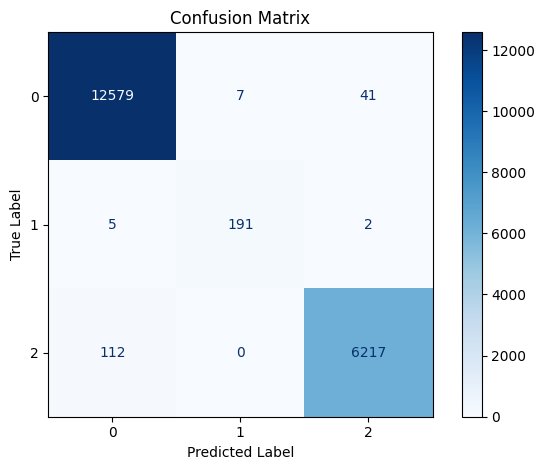

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_real, y_pred)
sensitivity, specificity = calculate_metrics_from_cm(cm)
print(sensitivity, specificity)
# Plot with custom labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
print(all_seizure.shape[0], all_base.shape[0], all_artifact.shape[0])
#fast.shape

#print(time_lfp.shape)
#trial_lfp_label = np.zeros((time_lfp.shape[0],3))
#print(trial_lfp_label.shape)

6329 12627 198


In [ ]:
def resample_multicolumn(t_old, data_old, fs_new, method='linear'):
    """
    Resample multi-column data to new sampling frequency
    
    Parameters:
    t_old: original time vector
    data_old: 2D array (n_samples, n_columns)  
    fs_new: new sampling frequency (Hz)
    method: interpolation method
    
    Returns:
    t_new, data_new: new time vector and resampled data
    """
    # Create new time vector
    duration = t_old[-1] - t_old[0]
    t_new = np.linspace(t_old[0], t_old[-1], int(duration * fs_new) + 1)
    
    # Interpolate all columns
    data_new = np.zeros((len(t_new), data_old.shape[1]))
    
    for col in range(data_old.shape[1]):
        f_interp = interpolate.interp1d(t_old, data_old[:, col], kind=method)
        data_new[:, col] = f_interp(t_new)
    
    return t_new, data_new


In [ ]:
sessionid = dataset.loc[:,"Animal"]==animalID
sessiontest = np.where(sessionid)[0]
print(metadata.Session[sessiontest])

0       2
11      3
19      4
29      5
39      6
49      7
58      8
71      9
77     10
86     11
97     12
109    14
118    15
128    16
139    17
150    18
160    19
Name: Session, dtype: int64


(351,)
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


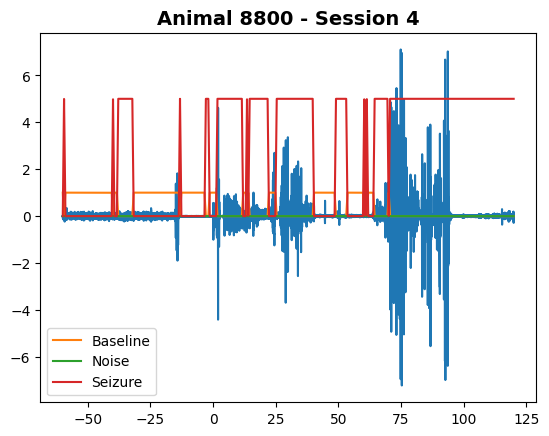

(351,)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


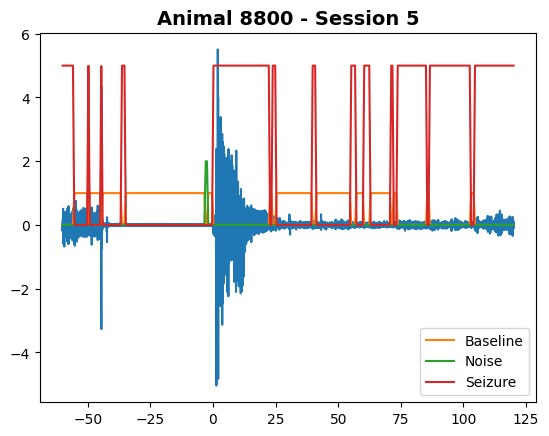

(351,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


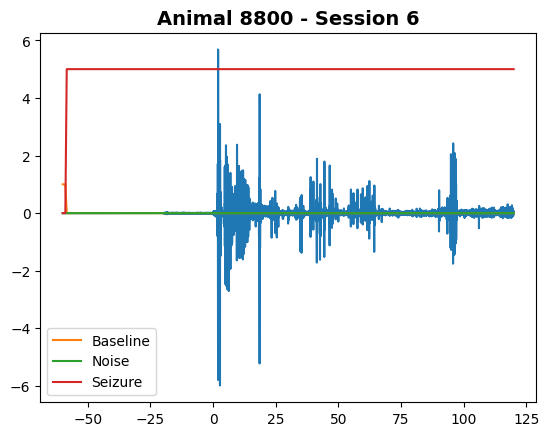

(351,)
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


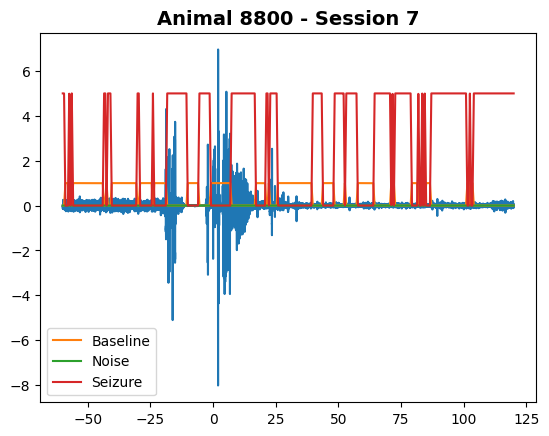

(351,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


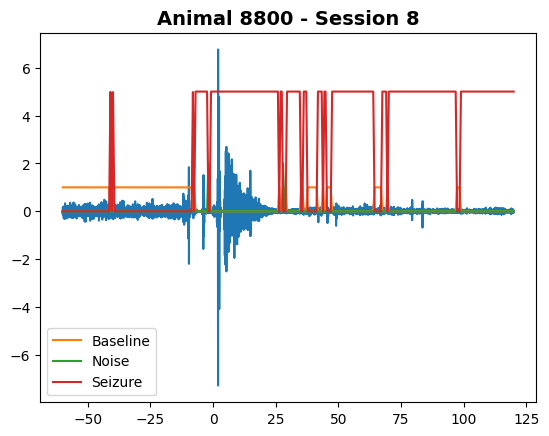

(351,)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


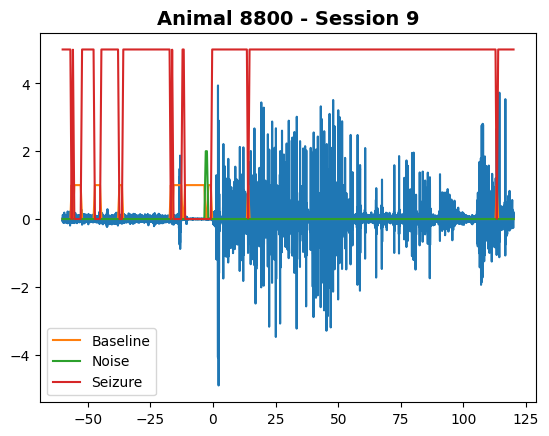

(351,)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


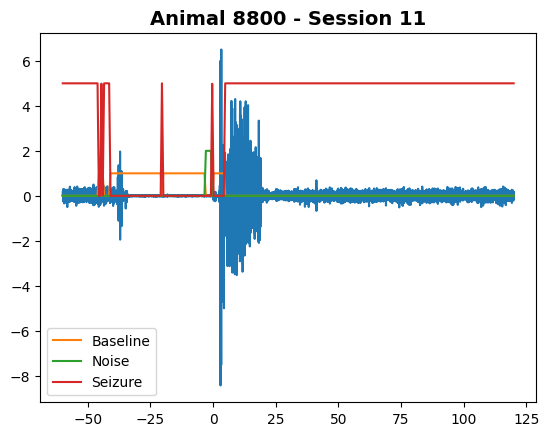

(351,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


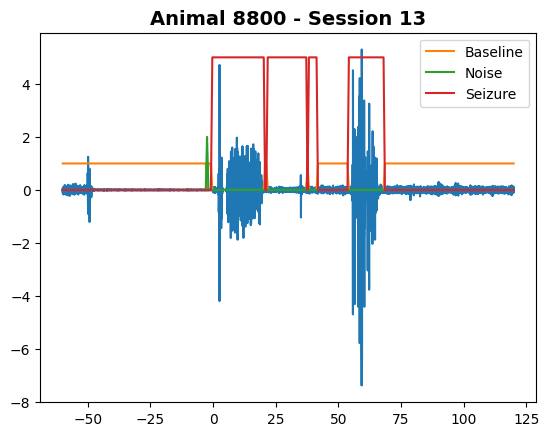

(351,)
[[1. 0. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


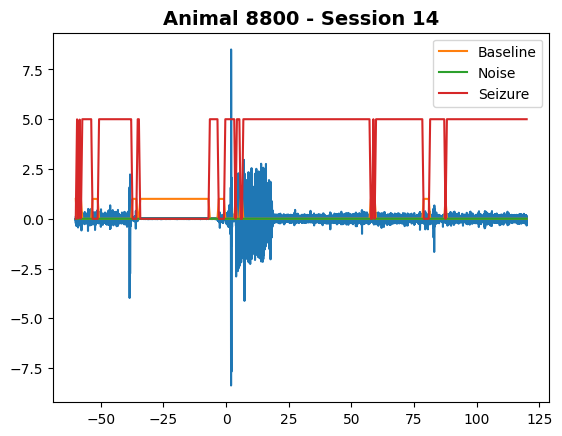

(351,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


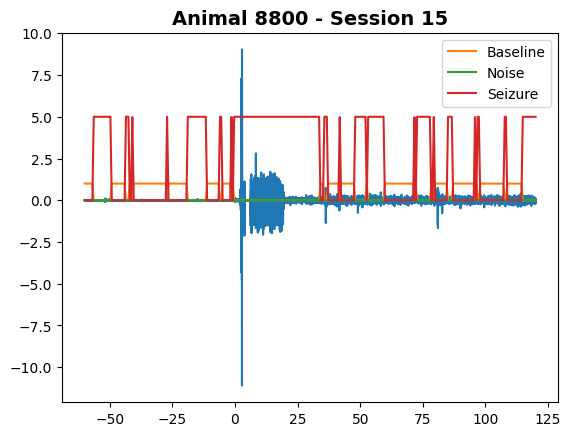

(351,)
[[0. 0. 1.]
 [0. 0. 1.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


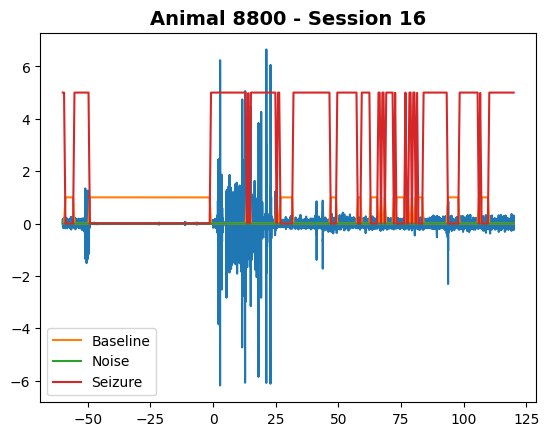

(351,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


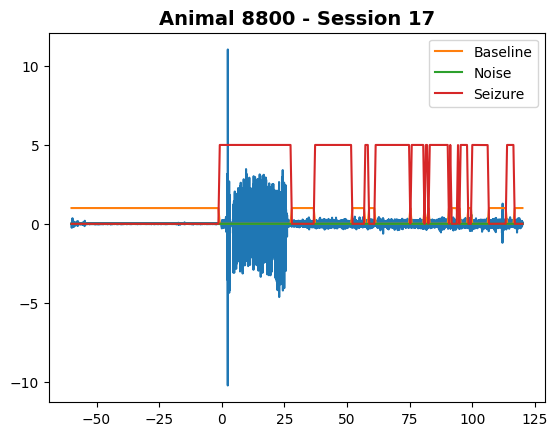

(351,)
[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


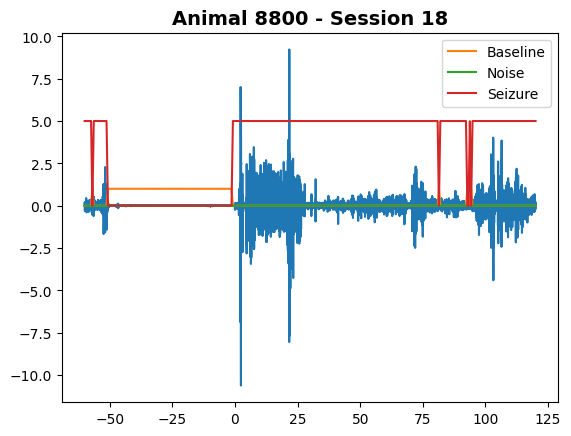

(351,)
[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 ...
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


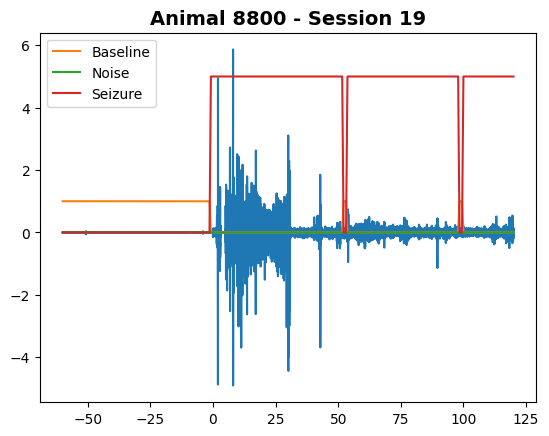

In [ ]:
import os
from pathlib import Path
from scipy import interpolate
#sessiontest = [20, 21, 22, 23, 24, 31, 46, 51, 55, 89, 150, 148, 110, 112, 114, 117, 120]
animalID = 8800
sessionid = dataset.loc[:,"Animal"]==animalID
sessiontest = np.where(sessionid)[0]
output_dir = Path("animal_plots_Seizure")
output_dir.mkdir(exist_ok=True)
#essiontest = [117, 118, 120, 122, 123]
start = -60
stop = 120
times = np.linspace(start, stop, len(times))
for s_in in sessiontest:
    
    sample = torch.tensor(psd_3d[s_in,:,1], device=DEVICE, dtype=torch.float32).reshape(1, -1)
    sample.shape
    out_trial_label = get_labels(net,s_in)
    print(out_trial_label)
    animal_label = str(int(animalID))
    session_label = str(int(metadata.Session[s_in]))
    title = f"Animal {animal_label} - Session {session_label}"
   
    time_lfp = np.linspace(-60, 120, fast.shape[1])
    trial_lfp_label = np.zeros((time_lfp.shape[0],3))
    times_lfp, trial_lfp_label = resample_multicolumn(times, out_trial_label, 200, method='linear')
    plt.figure()
    plt.plot(times_lfp,fast[s_in,:])
    plt.plot(times_lfp,trial_lfp_label[:,0], label=f'Baseline')
    plt.plot(times_lfp,trial_lfp_label[:,1]*2, label=f'Noise')
    plt.plot(times_lfp,trial_lfp_label[:,2]*5, label=f'Seizure')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.legend()
    
    filename = f"animal_{animal_label}_session_{session_label}.png"
    filepath = output_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [ ]:
print(sessiontest.shape)
print(low_freq)

(14,)
5


In [ ]:

print(metadata.Animal[117], metadata.Session[117])


12226 14


In [ ]:
import sys
print(sys.prefix)

/mnt/hdd/Workspace/MyThesisRecording/LeoFilestoRun/szenv
